# Kish Basin Salt Caverns

In [1]:
import glob
import os

import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
import xarray as xr
from geocube.api.core import make_geocube
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
# data directory
DATA_DIR = os.path.join("data", "kish-basin")

CRS = 23029

# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

## Read data layers

In [3]:
def read_dat_file(dat_path: str, dat_crs):
    """
    Read XYZ data layers into an Xarray dataset

    Parameters
    ----------
    dat_path : path to the .dat files
    dat_crs : CRS
    """

    gdf = {}
    # for dat_file in glob.glob(os.path.join(dat_path, "*.dat")):
    for dat_file in [
        x for x in glob.glob(
            os.path.join(dat_path, "*.dat")
        ) if "Zone" not in x
    ]:

        # read each layer as individual dataframes into a dictionary
        gdf[os.path.split(dat_file)[-1][:-4]] = pd.read_fwf(
            dat_file, header=None, names=["X", "Y", "Z"]
        )

        # assign layer name to a column
        gdf[os.path.split(dat_file)[-1][:-4]]["data"] = (
            os.path.split(dat_file)[-1][:-4]
        )

    # find data resolution
    gdf_xr = gdf[list(gdf.keys())[0]].set_index(["X", "Y"]).to_xarray()
    resx = gdf_xr["X"][1] - gdf_xr["X"][0]
    resy = gdf_xr["Y"][1] - gdf_xr["Y"][0]

    # combine dataframes
    gdf = pd.concat(gdf.values())

    # convert dataframe to geodataframe
    gdf["geometry"] = gpd.points_from_xy(gdf.X, gdf.Y, crs=dat_crs)
    gdf = gpd.GeoDataFrame(gdf)
    gdf.drop(columns=["X", "Y"], inplace=True)

    # convert to Xarray dataset
    xds = make_geocube(
        vector_data=gdf,
        resolution=(-abs(resy), abs(resx)),
        align=(abs(resy / 2), abs(resx / 2)),
        group_by="data"
    )

    # split variables and halite members
    xds_ = {}
    for d in xds["data"].values:
        halite_member = d.split(" ")[0]
        if halite_member == "Presall":
            halite_member = "Preesall"
        unit = d.split(" ")[-1]
        zvar = d.split("Halite ")[-1].split(" XYZ")[0]
        xds_[d] = xds.sel(data=d).assign_coords(
            halite=halite_member
        ).expand_dims(dim="halite").drop_vars("data")
        xds_[d] = xds_[d].rename({"Z": zvar.replace(" ", "")})
        xds_[d][zvar.replace(" ", "")] = (
            xds_[d][zvar.replace(" ", "")].assign_attrs(
                units=unit, long_name=zvar
            )
        )

    xds = xr.combine_by_coords(xds_.values(), combine_attrs="override")

    # # keep only points corresponding to zones of interest in the dataframe
    # zones = gdf.loc[gdf["data"].str.contains("Zone")]

    # # create zones of interest polygon
    # zones = gpd.GeoDataFrame(geometry=zones.buffer(100).envelope).dissolve()

    # create extent polygon
    dat_extent = pd.read_csv(
        os.path.join(DATA_DIR, "Kish GIS Map Extent - Square.csv"), skiprows=2
    )
    dat_extent = gpd.GeoSeries(
        shapely.geometry.Polygon([
            (dat_extent[" X"][0], dat_extent[" Y"][0]),
            (dat_extent[" X"][1], dat_extent[" Y"][1]),
            (dat_extent[" X"][2], dat_extent[" Y"][2]),
            (dat_extent[" X"][3], dat_extent[" Y"][3])
        ]),
        crs=dat_crs
    )

    return xds, dat_extent,  # zones

In [4]:
ds, extent = read_dat_file(DATA_DIR, CRS)

In [5]:
xmin, ymin, xmax, ymax = extent.total_bounds

In [6]:
def plot_facet_maps(dat_xr, dat_extent, dat_crs):
    """
    Helper function to plot facet maps of the halite layers

    Parameters
    ----------
    dat_xr : Xarray dataset of the halite data
    dat_extent : extent of the data
    dat_crs : CRS
    """

    xmin_, ymin_, xmax_, ymax_ = dat_extent.total_bounds

    for v in dat_xr.data_vars:
        fig = dat_xr[v].plot.contourf(
            col="halite",
            robust=True,
            levels=15,
            cmap="jet",
            col_wrap=2,
            subplot_kws={"projection": ccrs.epsg(dat_crs)},
            xlim=(xmin_, xmax_),
            ylim=(ymin_, ymax_)
        )
        # add a basemap
        basemap = cx.providers.CartoDB.PositronNoLabels
        for n, axis in enumerate(fig.axs.flat):
            cx.add_basemap(
                axis, crs=dat_crs, source=basemap, attribution=False
            )
            # add attribution for basemap tiles
            if n == 2:
                axis.text(
                    xmin_, ymin_ - 2500, basemap["attribution"], fontsize=8
                )
        fig.set_titles("{value}", weight="semibold")
        plt.show()

In [7]:
ds

<xarray.Dataset>
Dimensions:      (halite: 4, y: 237, x: 218)
Coordinates:
  * y            (y) float64 5.936e+06 5.936e+06 ... 5.889e+06 5.889e+06
  * x            (x) float64 6.966e+05 6.968e+05 6.97e+05 ... 7.398e+05 7.4e+05
    spatial_ref  int64 0
  * halite       (halite) <U8 'Flyde' 'Mythop' 'Preesall' 'Rossall'
Data variables:
    BaseDepth    (halite, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    Thickness    (halite, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    TopDepth     (halite, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    TopTWT       (halite, y, x) float64 nan nan nan nan nan ... nan nan nan nan

In [8]:
ds.rio.crs

CRS.from_epsg(23029)

In [9]:
ds.rio.resolution()

(200.0, -200.0)

In [10]:
ds.rio.bounds()

(696500.0, 5889100.0, 740100.0, 5936500.0)

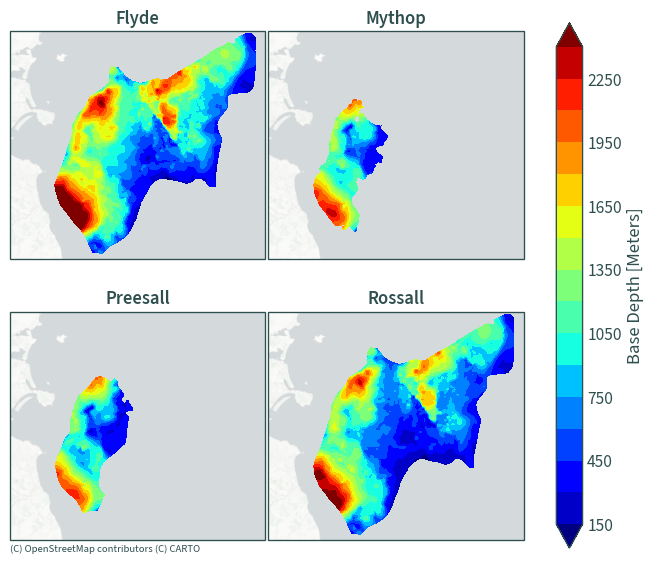

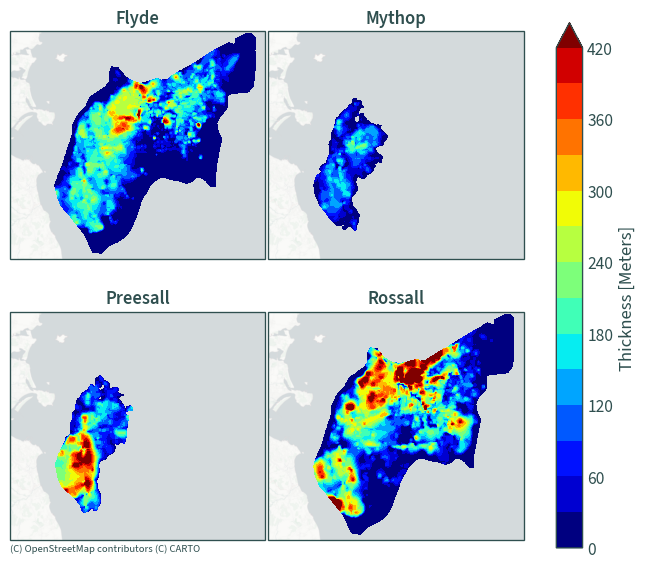

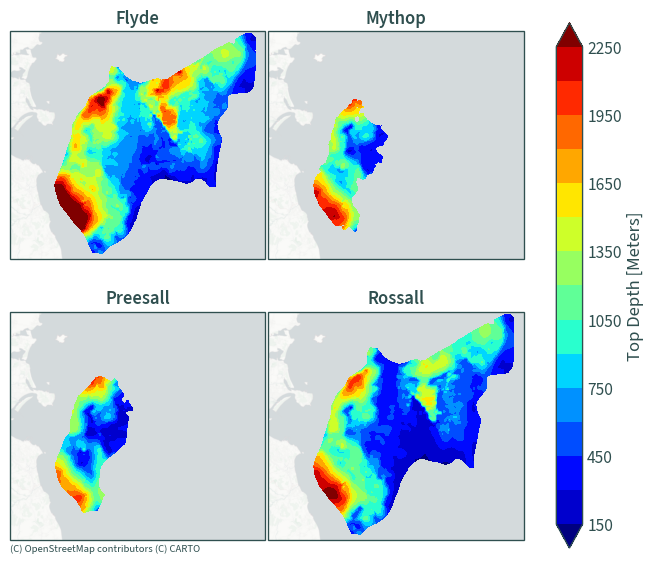

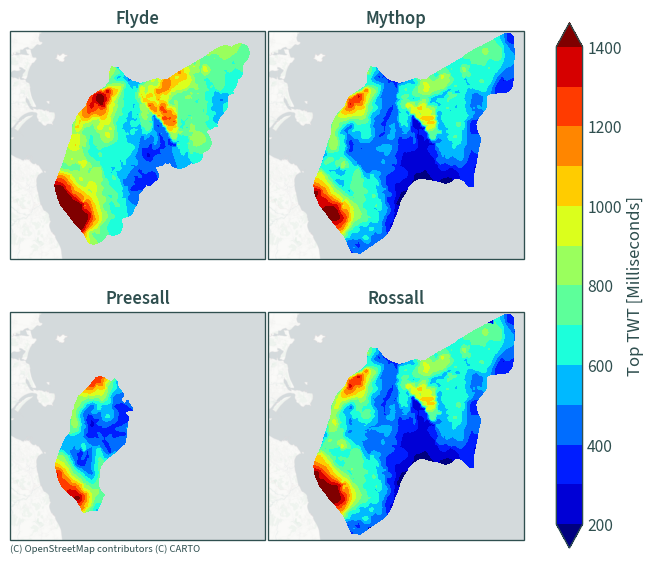

In [11]:
plot_facet_maps(ds, extent, CRS)

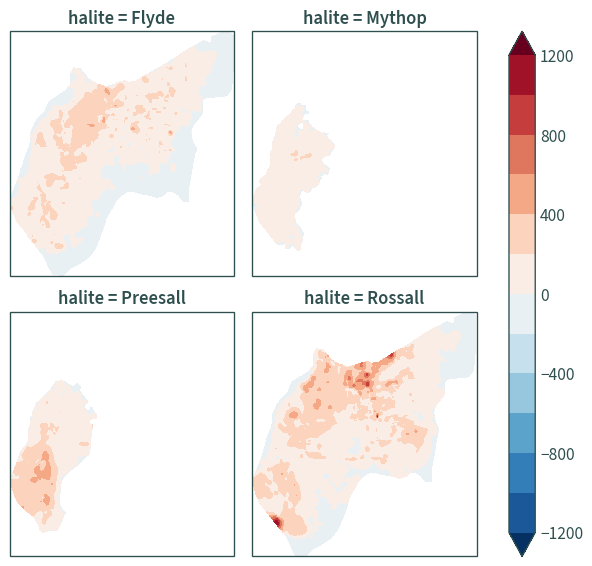

In [12]:
# compare depths
(ds["BaseDepth"] - ds["TopDepth"]).plot.contourf(
    col="halite", col_wrap=2, levels=15, extend="both",
    subplot_kws={"projection": ccrs.epsg(CRS)}
)
plt.show()

In [13]:
min(set((ds["BaseDepth"] - ds["TopDepth"]).values.flatten()))

-53.5

In [14]:
max(set((ds["BaseDepth"] - ds["TopDepth"]).values.flatten()))

1111.0679

## Zones of interest

In [15]:
def zones_of_interest(
    dat_xr, dat_extent, dat_crs, min_thickness, min_depth, max_depth
):
    """
    Generate a (multi)polygon of the zones of interest by applying thickness
    and depth constraints.

    Parameters
    ----------
    dat_xr : Xarray dataset of the halite data
    dat_extent : extent of the data
    dat_crs : CRS
    min_thickness : minimum halite thickness [m]
    min_depth : minimum halite top depth [m]
    max_depth : maximum halite top depth [m]

    Returns
    -------
    - A (multi)polygon geodataframe of the zones of interest
    """

    xmin_, ymin_, xmax_, ymax_ = dat_extent.total_bounds

    zdf = dat_xr.where(
        (
            (dat_xr.Thickness >= min_thickness)
            & (dat_xr.TopDepth >= min_depth)
            & (dat_xr.TopDepth <= max_depth)
        ),
        drop=True
    )

    # zones of interest polygon
    zdf = zdf.max(
        dim="halite"
    )["Thickness"].to_dataframe().dropna().reset_index()
    zdf = gpd.GeoDataFrame(
        geometry=gpd.GeoSeries(
            gpd.points_from_xy(zdf.x, zdf.y)
        ).buffer(100).envelope,
        crs=dat_crs
    ).dissolve()

    ax = plt.axes(projection=ccrs.epsg(dat_crs))
    zdf.boundary.plot(ax=ax, linewidth=1, color="darkslategrey")
    plt.xlim(xmin_, xmax_)
    plt.ylim(ymin_, ymax_)
    cx.add_basemap(
        ax, source=cx.providers.CartoDB.PositronNoLabels, crs=dat_crs
    )
    plt.title("Zones of interest")
    plt.tight_layout()
    plt.show()

    return zdf

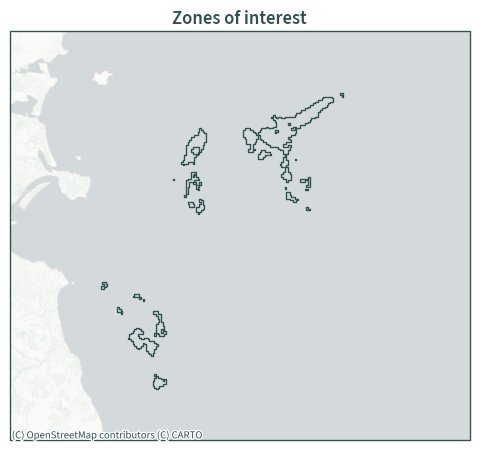

In [16]:
# recommendations from the Hystories project
# salt thickness >= 300 m, top depth >= 1000 m and <= 1500 m
zones = zones_of_interest(ds, extent, CRS, 300, 1000, 1500)

## Generate potential salt cavern locations

In [17]:
def plot_map(dat_xr, dat_extent, dat_crs, cavern_df, var, stat):
    """
    Helper function to plot halite layer and caverns within the zones of
    interest

    Parameters
    ----------
    dat_xr : Xarray dataset of the halite data
    dat_extent : extent of the data
    dat_crs : CRS
    cavern_df : cavern distribution
    var : variable
    stat : statistic (max / min / mean)
    """

    xmin_, ymin_, xmax_, ymax_ = dat_extent.total_bounds

    plt.figure(figsize=(12, 9))
    ax = plt.axes(projection=ccrs.epsg(dat_crs))

    cbar_label = (
        f"{dat_xr[var].attrs['long_name']} [{dat_xr[var].attrs['units']}]"
    )

    if stat == "max":
        plot_data = dat_xr.max(dim="halite", skipna=True)
        cbar_label = f"Maximum {cbar_label}"
    elif stat == "min":
        plot_data = dat_xr.min(dim="halite", skipna=True)
        cbar_label = f"Minimum {cbar_label}"
    elif stat == "mean":
        plot_data = dat_xr.mean(dim="halite", skipna=True)
        cbar_label = f"Mean {cbar_label}"

    plot_data[var].plot.contourf(
        cmap="jet",
        alpha=.65,
        robust=True,
        levels=15,
        cbar_kwargs={"label": cbar_label}
    )
    plt.xlim(xmin_, xmax_)
    plt.ylim(ymin_, ymax_)
    cavern_df.centroid.plot(
        ax=ax, markersize=7, color="black", label="Cavern", edgecolor="none"
    )
    cx.add_basemap(ax, crs=dat_crs, source=cx.providers.CartoDB.Voyager)
    ax.gridlines(
        draw_labels={"bottom": "x", "left": "y"},
        alpha=.25, color="darkslategrey"
    )
    ax.add_artist(
        ScaleBar(
            1, box_alpha=0,  # font_properties={"size": "large"},
            location="lower right", color="darkslategrey"
        )
    )
    plt.legend(loc="lower right", bbox_to_anchor=(1, 0.05), markerscale=1.75)
    plt.title(None)
    plt.tight_layout()
    plt.show()

### Cavern calculations based on Caglayan *et al.* (2020)

<https://doi.org/10.1016/j.ijhydene.2019.12.161>

#### Cavern distribution function

In [18]:
def generate_caverns_caglayan_etal(
    dat_extent, dat_crs, zones_df, diameter, separation
):
    """
    Generate salt caverns using a regular square grid within the zones of
    interest based on the methodology by Caglayan et al. (2020):
    https://doi.org/10.1016/j.ijhydene.2019.12.161.
    Gridding method based on
    https://james-brennan.github.io/posts/fast_gridding_geopandas/.

    Parameters
    ----------
    dat_extent : extent of the data
    dat_crs : CRS
    zones_df : zones of interest
    diameter : diameter of the cavern [m]
    separation : cavern separation distance [m]

    Returns
    -------
    - A polygon geodataframe of potential caverns
    """

    xmin_, ymin_, xmax_, ymax_ = dat_extent.total_bounds

    # create the cells in a loop
    grid_cells = []
    for x0 in np.arange(xmin_, xmax_ + separation, separation):
        for y0 in np.arange(ymin_, ymax_ + separation, separation):
            # bounds
            x1 = x0 - separation
            y1 = y0 + separation
            grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))
    grid_cells = gpd.GeoDataFrame(
        grid_cells, columns=["geometry"], crs=dat_crs
    )

    # generate caverns within the zones of interest
    cavern_df = gpd.sjoin(
        gpd.GeoDataFrame(
            geometry=grid_cells.centroid.buffer(diameter / 2)
        ).drop_duplicates(),
        zones_df,
        predicate="within"
    )

    # estimates
    print("Number of potential caverns:", len(cavern_df))
    print(f"Total volume: {len(cavern_df) * 5e5:.2E} m\N{SUPERSCRIPT THREE}")
    print(f"Storage capacity: {len(cavern_df) * 146.418 / 1e3:.2f} TWh")

    return cavern_df

#### Cavern capacity calculations

In [19]:
def cavern_capacity_caglayan_etal(
    depth,
    rho_rock,
    m,
    z,
    v_cavern,
    lhv_gas,
    cavern_height=120
):
    """
    t_avg : average gas temperature [K]
    depth : depth of the bottom tip of the salt cavern [m]
    cavern_height : height of the cavern [m]
    p_overburden : overburden / lithostatic pressure
    rho_rock : rock density [kg m-3]
    g : gravitational acceleration [9.81 m s-2]
    rho_h2 : density of hydrogen gas [kg m-3]
    z : compressibility factor
    p : pressure [Pa]
    m : molar mass of the species [kg mol-1]
    r : universal gas constant [8.314 J K-1 mol-1]
    t : temperature [K]
    m_working_gas : mass of the working gas [kg]
    v_cavern : cavern volume [m3]
    theta_safety : safety factor [70%]
    cavern_capacity : energy storage capacity of cavern [GWhH2]
    lhv_gas : lower heating value of the gas [GWhH2 kg-1]
    """

    # eq. (1)
    t_avg = 288 + 0.025 * (depth - cavern_height / 2)

    # eq. (2)
    # p_overburden = rho_rock * g * (depth - cavern_height)
    p_overburden = rho_rock * 9.81 * (depth - cavern_height)

    # eq. (3)
    # rho_h2 = (p * m) / (z * r * t)
    rho_h2_max = (p_overburden * 0.8 * m) / (z * 8.314 * t_avg)
    rho_h2_min = (p_overburden * 0.24 * m) / (z * 8.314 * t_avg)

    # eq. (4)
    # m_working_gas = (rho_h2_max - rho_h2_min) * v_cavern * theta_safety
    m_working_gas = (rho_h2_max - rho_h2_min) * v_cavern * 0.7

    # eq. (5)
    cavern_capacity = m_working_gas * lhv_gas

#### Generate caverns

In [20]:
# max 80 m diameter based on Hystories
# separation distance of 4 times the diameter as recommended by Caglayan et al.
caverns = generate_caverns_caglayan_etal(extent, CRS, zones, 80, 80 * 4)

Number of potential caverns: 344
Total volume: 1.72E+08 m³
Storage capacity: 50.37 TWh


In [21]:
# 85 m diameter and 330 m separation distance as used by HYSS
caverns = generate_caverns_caglayan_etal(extent, CRS, zones, 85, 330)

Number of potential caverns: 346
Total volume: 1.73E+08 m³
Storage capacity: 50.66 TWh


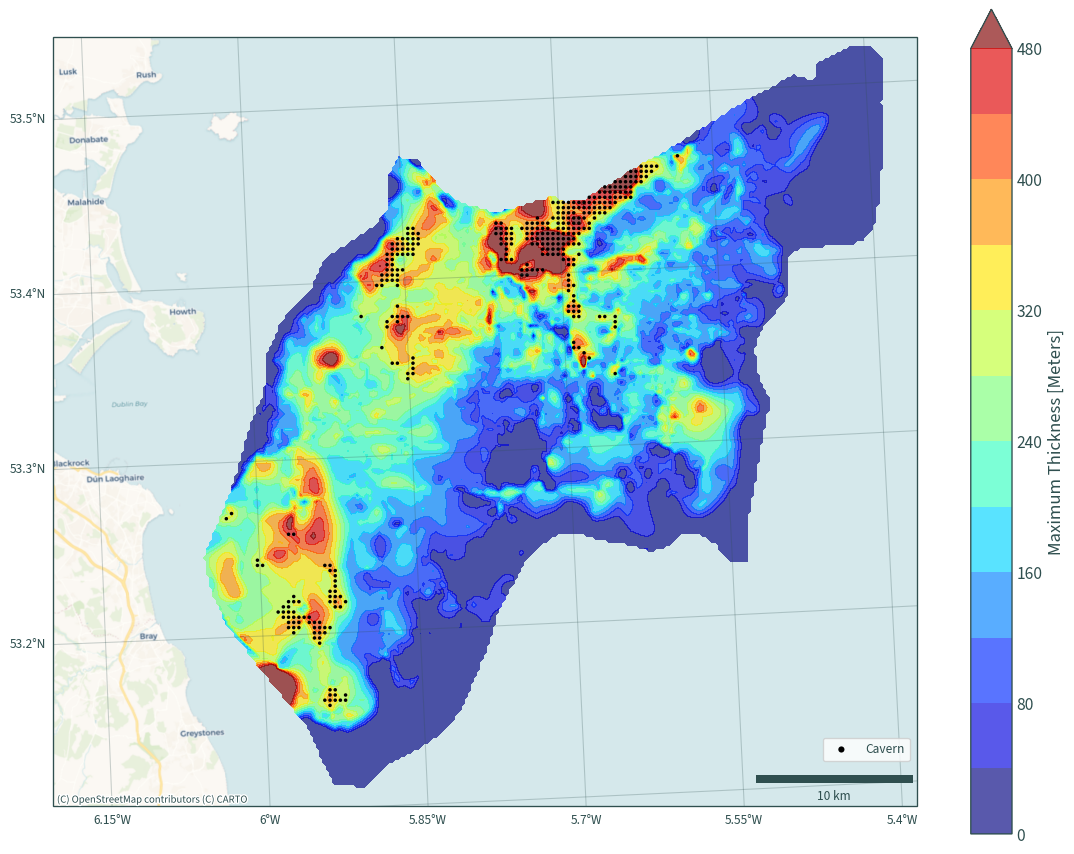

In [22]:
plot_map(ds, extent, CRS, caverns, "Thickness", "max")

### Cavern calculations based on Williams *et al.* (2022)

<https://doi.org/10.1016/j.est.2022.105109>

#### Cavern distribution function

In [23]:
def generate_caverns_williams_etal(
    dat_extent, dat_crs, zones_df, diameter, separation
):
    """
    Generate caverns in a regular hexagonal grid as proposed by Williams
    et al. (2022): https://doi.org/10.1016/j.est.2022.105109.
    Hexagonal gridding method based on
    https://sabrinadchan.github.io/data-blog/building-a-hexagonal-cartogram.html.

    Parameters
    ----------
    dat_extent : extent of the data
    dat_crs : CRS
    zones_df : zones of interest
    diameter : diameter of the cavern [m]
    separation : cavern separation distance [m]

    Returns
    -------
    - A polygon geodataframe of potential caverns
    """

    xmin_, ymin_, xmax_, ymax_ = dat_extent.total_bounds

    a = np.sin(np.pi / 3)
    cols = np.arange(np.floor(xmin_), np.ceil(xmax_), 3 * separation)
    rows = np.arange(np.floor(ymin_) / a, np.ceil(ymax_) / a, separation)

    hexagons = []
    cavern_df = []
    for x in cols:
        for i, y in enumerate(rows):
            if (i % 2 == 0):
                x0 = x
            else:
                x0 = x + 1.5 * separation

            # hexagon vertices
            cavern_df.append(shapely.geometry.Point(x0, y * a))
            cavern_df.append(shapely.geometry.Point(x0 + separation, y * a))
            cavern_df.append(
                shapely.geometry.Point(
                    x0 + (1.5 * separation), (y + separation) * a
                    )
                )
            cavern_df.append(
                shapely.geometry.Point(
                    x0 + separation, (y + (2 * separation)) * a
                )
            )
            cavern_df.append(
                shapely.geometry.Point(x0, (y + (2 * separation)) * a)
            )
            cavern_df.append(
                shapely.geometry.Point(
                    x0 - (0.5 * separation), (y + separation) * a
                )
            )
            # hexagon centroid
            cavern_df.append(
                shapely.geometry.Point(
                    x0 + (0.5 * separation), (y + separation) * a
                )
            )

    # generate caverns using hexagon vertices and centroids
    cavern_df = gpd.GeoDataFrame(
        geometry=gpd.GeoDataFrame(
            geometry=cavern_df, crs=dat_crs
        ).drop_duplicates().buffer(diameter / 2)
    )

    # clip caverns to the zones of interest
    cavern_df = gpd.sjoin(cavern_df, zones_df, predicate="within")

    # estimates
    print("Number of potential caverns:", len(cavern_df))
    print(f"Total volume: {len(cavern_df) * 5e5:.2E} m\N{SUPERSCRIPT THREE}")
    print(f"Storage capacity: {len(cavern_df) * 105.074 / 1e3:.2f} TWh")

    return cavern_df

In [24]:
# max 80 m diameter based on Hystories
# separation distance of 4 times the diameter as recommended by Caglayan et al.
caverns = generate_caverns_williams_etal(extent, CRS, zones, 80, 80 * 4)

Number of potential caverns: 409
Total volume: 2.04E+08 m³
Storage capacity: 42.98 TWh


In [25]:
# 85 m diameter and 330 m separation distance as used by HYSS
caverns = generate_caverns_williams_etal(extent, CRS, zones, 85, 330)

Number of potential caverns: 391
Total volume: 1.96E+08 m³
Storage capacity: 41.08 TWh


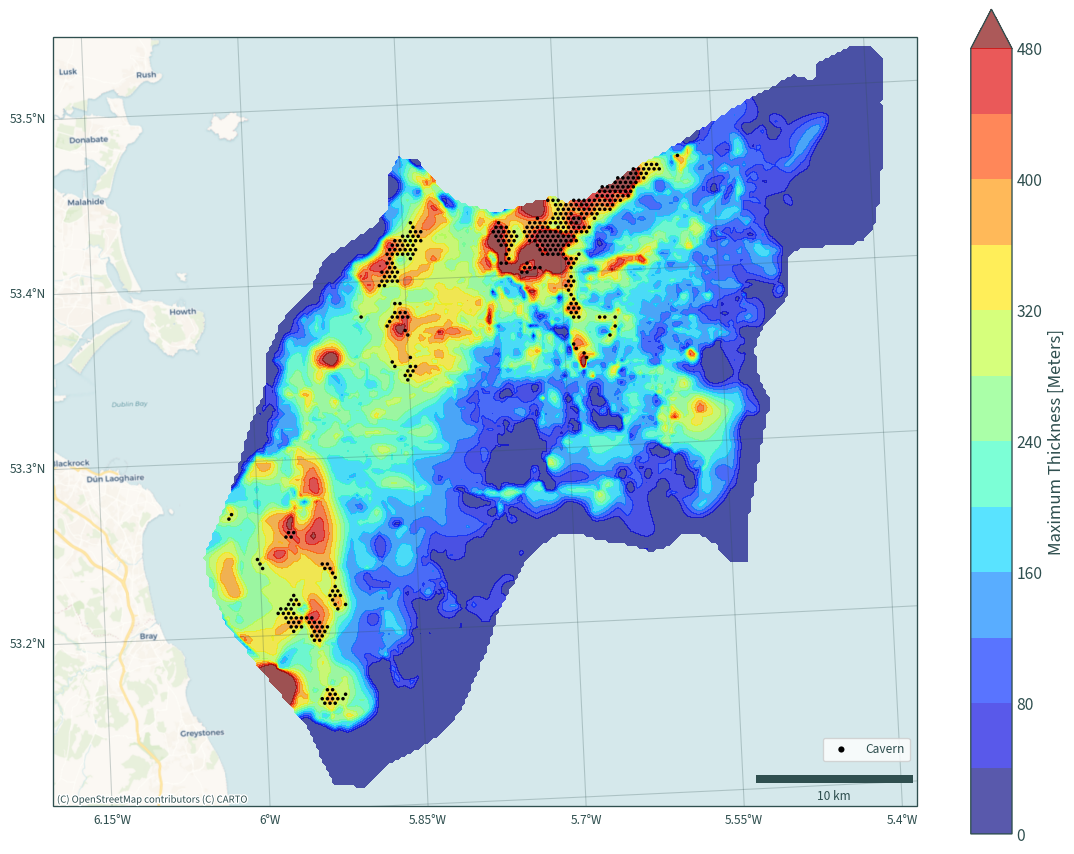

In [26]:
plot_map(ds, extent, CRS, caverns, "Thickness", "max")